##Importación de librerías necesarias

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/UD3kmeans/Country-data.csv")

In [ ]:
df1.head().T

,0,1,2,3,4
country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda
child_mort,90.2,16.6,27.3,119.0,10.3
exports,10.0,28.0,38.4,62.3,45.5
health,7.58,6.55,4.17,2.85,6.03
imports,44.9,48.6,31.4,42.9,58.9
income,1610,9930,12900,5900,19100
inflation,9.44,4.49,16.1,22.4,1.44
life_expec,56.2,76.3,76.5,60.1,76.8
total_fer,5.82,1.65,2.89,6.16,2.13
gdpp,553,4090,4460,3530,12200


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/UD3kmeans/data-dictionary.csv")

In [ ]:
df2

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 100...
2,exports,Exports of goods and services per capita. Give...
3,health,Total health spending per capita. Given as %ag...
4,imports,Imports of goods and services per capita. Give...
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of t...
7,life_expec,The average number of years a new born child w...
8,total_fer,The number of children that would be born to e...
9,gdpp,The GDP per capita. Calculated as the Total GD...


##Preprocesamiento y elección de variables relevantes para el estudio.

Filtrado de nulos

In [ ]:
df1.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Conversion del dataframe to numpy array y solo nos quedamos con las columnas mas significativas

In [ ]:
df1.drop(["country","child_mort","total_fer"], axis = 1, inplace=True)

In [ ]:
df1.columns

Index(['exports', 'health', 'imports', 'income', 'inflation', 'life_expec',
       'gdpp'],
      dtype='object')

In [ ]:
df1

,exports,health,imports,income,inflation,life_expec,gdpp
0,10.0,7.58,44.9,1610,9.44,56.2,553
1,28.0,6.55,48.6,9930,4.49,76.3,4090
2,38.4,4.17,31.4,12900,16.10,76.5,4460
3,62.3,2.85,42.9,5900,22.40,60.1,3530
4,45.5,6.03,58.9,19100,1.44,76.8,12200
...,...,...,...,...,...,...,...
162,46.6,5.25,52.7,2950,2.62,63.0,2970
163,28.5,4.91,17.6,16500,45.90,75.4,13500
164,72.0,6.84,80.2,4490,12.10,73.1,1310
165,30.0,5.18,34.4,4480,23.60,67.5,1310


In [ ]:
df_x = df1.to_numpy()

In [ ]:
X = df_x

In [ ]:
# X

## Detección del número de clusters

Por tratarse de un caso real el número de clusters $K$ es desconocido. Vamos a aplicar  el criterio basado en el BIC para el cálculo de este hiperparámetro, para ello haremos uso de la función *BIC* (previamente empleada en el Ejemplo 6.1).  

Tras ejecutar el siguiente código podemos observar que el BIC crece hasta $K=10$ y que el minimo es 2. Por lo tanto $K=2$ será el valor elegido.

In [ ]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

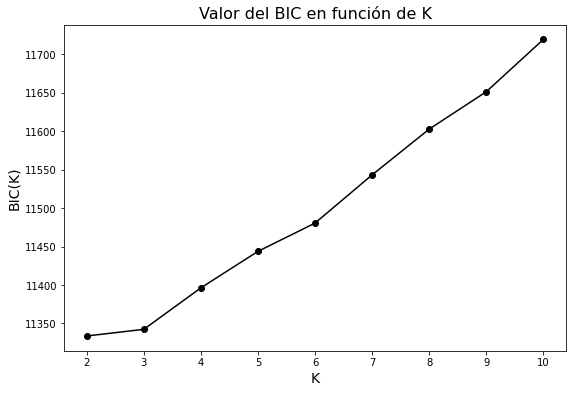

In [ ]:
## Calculo del BIC
Kmax = 10
BIC_array = []
for k in range(2, Kmax+1):
  kmeans = KMeans(n_clusters=k, n_init=15, random_state=100)
  grupos = kmeans.fit_predict(X)
  BIC_array.append(BIC(k, grupos, X))

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(9, 6))
plt.plot(np.arange(2, Kmax+1), BIC_array, "ko-")
plt.title("Valor del BIC en función de K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.show()

## Detección de outliers (anomalías)

Vamos a aplicar el método de Jackknife para detectar las observaciones influyentes.  El siguiente código detecta los outliers y los elimina del análisis y los representa visualmente. Notar que si el número de réplicas en el número de veces que se realiza el algoritmo de las k-medias es pequeño el procedimiento detecta diferentes conjunto de outliers ya que llega a diferentes soluciones. Hemos fijado este valor a $30$.

In [ ]:
## Detección de outliers
N = X.shape[0] # Número de observaciones
K = 2 # Número de clusters el que se ve en el grafico

SSE = []
for i in range(0, N):
  X_sin_i = np.delete(X, i, axis=0) # Eliminamos la observación i
  # Aplicamos K-medias a X_sin_i y obtenemos el índice SSE
  kmeans = KMeans(n_clusters=K, n_init=30, random_state=100).fit(X_sin_i)
  SSE.append(kmeans.inertia_)

In [ ]:
min(SSE)

29873138911.18096

In [ ]:
max(SSE)

36527921468.68094

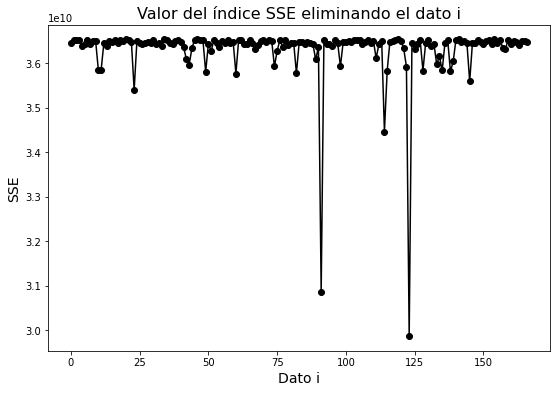

In [ ]:
## Detección visual de outliers
# Dibujamos el SSE obtenido eliminando cada observación
plt.figure(figsize=(9, 6))
plt.plot(np.arange(0, N), SSE, "ko-")
plt.title("Valor del índice SSE eliminando el dato i", fontsize=16)
plt.xlabel("Dato i", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.show()

In [ ]:
## Detección analítica de outliers
sigma = np.std(SSE) # Desviación típica de SSE
mu = np.mean(SSE) # Media
umbral = 2 # Umbral: 2 para distribuciones normales y 3 para cualquier otra distribución

outliers = []
for i in range(0, N):
  if np.abs(SSE[i]-mu) > umbral*sigma:
    outliers.append(i)
print(outliers)

[91, 114, 123]


In [ ]:
## Eliminación de los outliers
X_new = np.delete(X, outliers, axis=0)
X_new.shape

(164, 7)

In [ ]:
df = df1.drop(outliers,axis=0)

## Determinación de patrones y estudio

Finalmente calculamos los patrones mediante el algoritmo $K-$means, los repesentamos gráficamente

In [ ]:
## Cálculo de patrones
kmeans = KMeans(n_clusters=K, n_init=30, random_state=100)
pred = kmeans.fit_predict(X_new)
centroides = kmeans.cluster_centers_

In [ ]:
centroides

array([[5.54833333e+01, 8.57388889e+00, 4.88444444e+01, 4.13138889e+04,
        3.78991667e+00, 7.92555556e+01, 3.70500000e+04],
       [3.58656172e+01, 6.33203125e+00, 4.59216086e+01, 8.56924219e+03,
        8.95764844e+00, 6.78734375e+01, 4.43839062e+03]])

In [ ]:
df["label"] = pred

In [ ]:
df.head().T

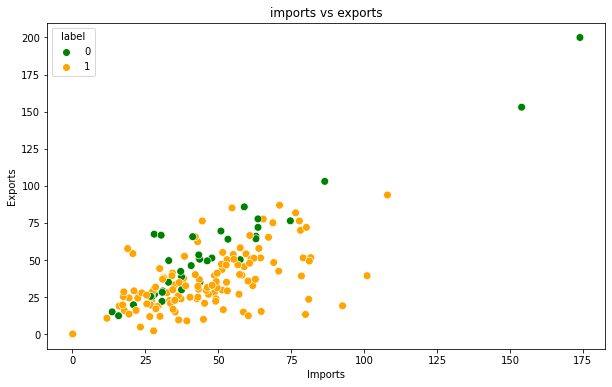

In [ ]:
#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'imports',y = 'exports',hue="label",  
                 palette=['green','orange'], legend='full',data = df  ,s = 60 )
plt.xlabel('Imports')
plt.ylabel('Exports') 
plt.title('imports vs exports')
plt.show()

In [ ]:
N_patron = np.bincount(pred) # Contar el número veces del label que se repite 
tabla = pd.DataFrame(columns=["Número de grupo", "Número de observaciones del grupo","Centroide:característica exports",
                              "Centroide:característica health", "Centroide:característica imports","Centroide:característica income",
                              "Centroide:característica inflation", "Centroide:característica life_expec","Centroide:característica gdpp"])

for k in range(K):
  tabla.loc[k, "Número de grupo"] = k
  tabla.loc[k, "Número de observaciones del grupo"] = N_patron[k]  
  tabla.loc[k, "Centroide:característica exports"] = centroides[k][0]
  tabla.loc[k, "Centroide:característica health"] = centroides[k][1]
  tabla.loc[k, "Centroide:característica imports"] = centroides[k][2]
  tabla.loc[k, "Centroide:característica income"] = centroides[k][3]
  tabla.loc[k, "Centroide:característica inflation"] = centroides[k][4]
  tabla.loc[k, "Centroide:característica life_expec"] = centroides[k][5]
  tabla.loc[k, "Centroide:característica gdpp"] = centroides[k][6]
    

# Mostrar la tabla
display(tabla)

,Número de grupo,Número de observaciones del grupo,Centroide:característica exports,Centroide:característica health,Centroide:característica imports,Centroide:característica income,Centroide:característica inflation,Centroide:característica life_expec,Centroide:característica gdpp
0,0,36,55.483333,8.573889,48.844444,41313.888889,3.789917,79.255556,37050.0
1,1,128,35.865617,6.332031,45.921609,8569.242188,8.957648,67.873437,4438.390625


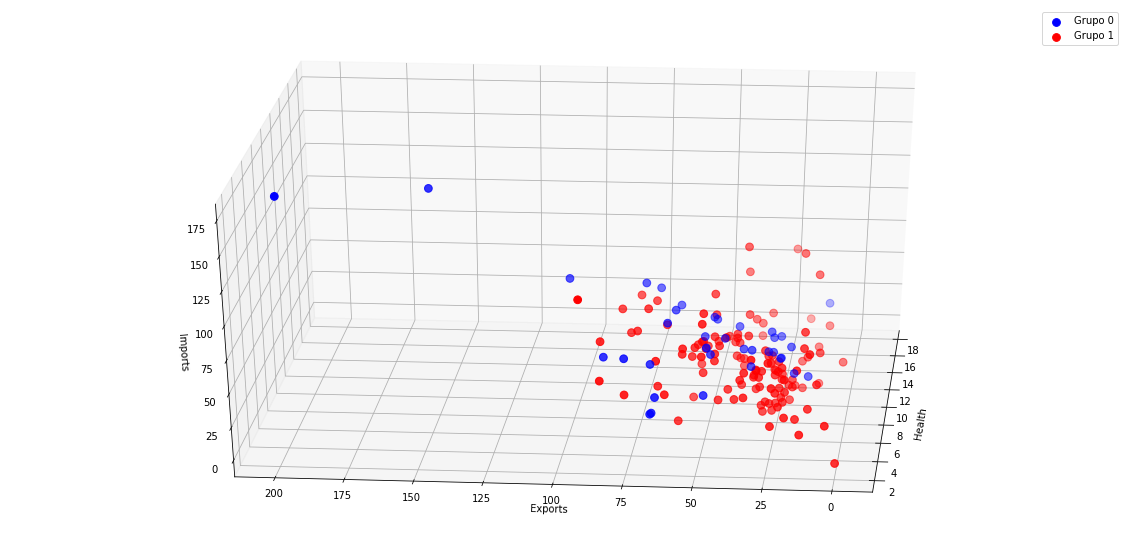

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.health[df.label == 0], df["exports"][df.label == 0], df["imports"][df.label == 0], c='blue', label='Grupo 0', s=60)
ax.scatter(df.health[df.label == 1], df["exports"][df.label == 1], df["imports"][df.label == 1], c='red', label='Grupo 1' , s=60)

ax.view_init(30, 185)


plt.xlabel("Health")
plt.ylabel("Exports")
ax.set_zlabel('Imports')

# produce a legend with the unique colors from the scatter
ax.legend()



plt.show()